In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, csv
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import Callback

## Reading Data

In [6]:
# Load .npy files using numpy's load function
X_embed_1 = np.load('../data/embeddings_1.npy')
X_embed_2 = np.load('../data/embeddings_2.npy')

# Load text files using standard Python open function
with open('../data/icd_codes_1.txt', 'r') as file:
    label_embed_1 = file.read().strip()  # Remove any leading/trailing whitespace

with open('../data/icd_codes_2.txt', 'r') as file:
    label_embed_2 = file.read().strip()  # Remove any leading/trailing whitespace

# Create DataFrames from the numpy arrays
df_embed_1 = pd.DataFrame(X_embed_1)
df_embed_2 = pd.DataFrame(X_embed_2)

# Split the labels by newline and assign to the DataFrame
df_embed_1['labels'] = label_embed_1.split('\n')
df_embed_2['labels'] = label_embed_2.split('\n')

# Concatenate the DataFrames
df = pd.concat([df_embed_1, df_embed_2], ignore_index=True)

# Split the labels by semicolon
df['labels'] = df['labels'].apply(lambda x: x.split(';'))

df.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,labels
0,-0.138629,-0.229309,-0.691909,0.174990,-0.147606,0.546933,-0.711464,0.086546,0.175574,0.150720,...,-0.066820,-0.106462,-0.180066,0.170044,-0.998879,0.622624,0.719849,-0.108738,1.254957,[H65.23]
1,1.338272,-0.123468,0.522916,-0.761171,-0.243275,0.550109,0.205095,0.596237,0.369073,-0.251638,...,-0.671389,0.732121,-0.907783,-0.572734,-0.021818,0.300998,0.386684,-0.597378,0.522281,"[G89.29, M25.562]"
2,-0.313802,-0.717166,0.303416,0.653793,-0.693514,0.032964,-0.263691,-0.205346,-0.080448,-0.094282,...,0.184446,0.368608,-0.418135,0.059209,-0.327019,0.145836,0.399618,-0.130010,-0.124595,"[R13.10, K20.90, K31.89, K25.9, K29.80]"
3,-0.617688,-0.830042,-0.126423,-0.410705,-0.054841,-0.296524,0.620169,0.229296,-0.559252,0.410969,...,0.894020,-0.192655,-0.007297,-0.450359,0.597864,0.270095,-0.072449,1.206772,0.180913,"[K20.90, R10.11, Z86.010, K57.30, Z90.49]"
4,0.740153,0.449349,0.072621,-0.370613,0.507154,-0.197308,0.175400,0.142559,-0.202709,0.360109,...,-0.199335,-0.067989,-1.119830,0.564957,-0.118936,-0.074200,0.728665,0.398697,-0.083612,"[R93.3, K29.50, R10.84, K31.89, R19.7]"


In [28]:
# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the labels
label = mlb.fit_transform(df['labels'])
data = df.drop('labels', axis=1)

# Display the first 5 binarized labels
print([sum(label[x]) for x in range(5)])

[1, 2, 5, 5, 5]


## EDA

In [8]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
count,198982.000000,198982.000000,198982.000000,198982.000000,198982.000000,198982.000000,198982.000000,198982.000000,198982.000000,198982.000000,...,198982.000000,198982.000000,198982.000000,198982.000000,198982.000000,198982.000000,198982.000000,198982.000000,198982.000000,198982.000000
mean,0.035745,-0.294374,0.128021,-0.045989,0.135025,0.165583,0.141005,0.210744,0.044245,0.166036,...,0.135938,-0.149924,0.169551,-0.278326,-0.202134,-0.293193,-0.048600,0.195960,-0.062492,-0.260584
std,0.586197,0.544019,0.484706,0.462903,0.493444,0.543678,0.535328,0.679119,0.439765,0.593359,...,0.497618,0.550216,0.556654,0.587536,0.483765,0.528216,0.469768,0.466822,0.562808,0.471618
min,-2.740032,-3.090216,-2.013178,-2.013793,-1.914606,-2.474727,-1.891813,-2.411139,-2.246568,-2.411163,...,-2.413746,-2.338831,-2.153770,-3.441448,-2.403991,-2.658768,-2.404126,-2.063895,-2.297032,-2.417359
25%,-0.343048,-0.615425,-0.191701,-0.352066,-0.187253,-0.204832,-0.241014,-0.265104,-0.230462,-0.242301,...,-0.181736,-0.523233,-0.199534,-0.654046,-0.532304,-0.627419,-0.354956,-0.105238,-0.419187,-0.572498
50%,0.057421,-0.272910,0.128209,-0.063266,0.130576,0.162721,0.140415,0.188593,0.048892,0.155200,...,0.151579,-0.150445,0.171718,-0.272876,-0.201075,-0.280770,-0.043338,0.199977,-0.068559,-0.262996
75%,0.422088,0.061503,0.441731,0.232272,0.452494,0.529459,0.508897,0.647916,0.322835,0.579068,...,0.458366,0.203639,0.543165,0.113303,0.113599,0.058220,0.278209,0.499266,0.296908,0.050135
max,2.296288,2.658804,2.290709,2.455730,2.301424,2.424623,2.270932,2.776699,2.173027,2.674361,...,2.392430,2.417791,2.360754,2.086018,1.935782,1.869010,1.890795,2.107716,3.020952,2.200516


In [9]:
data = data.to_numpy()

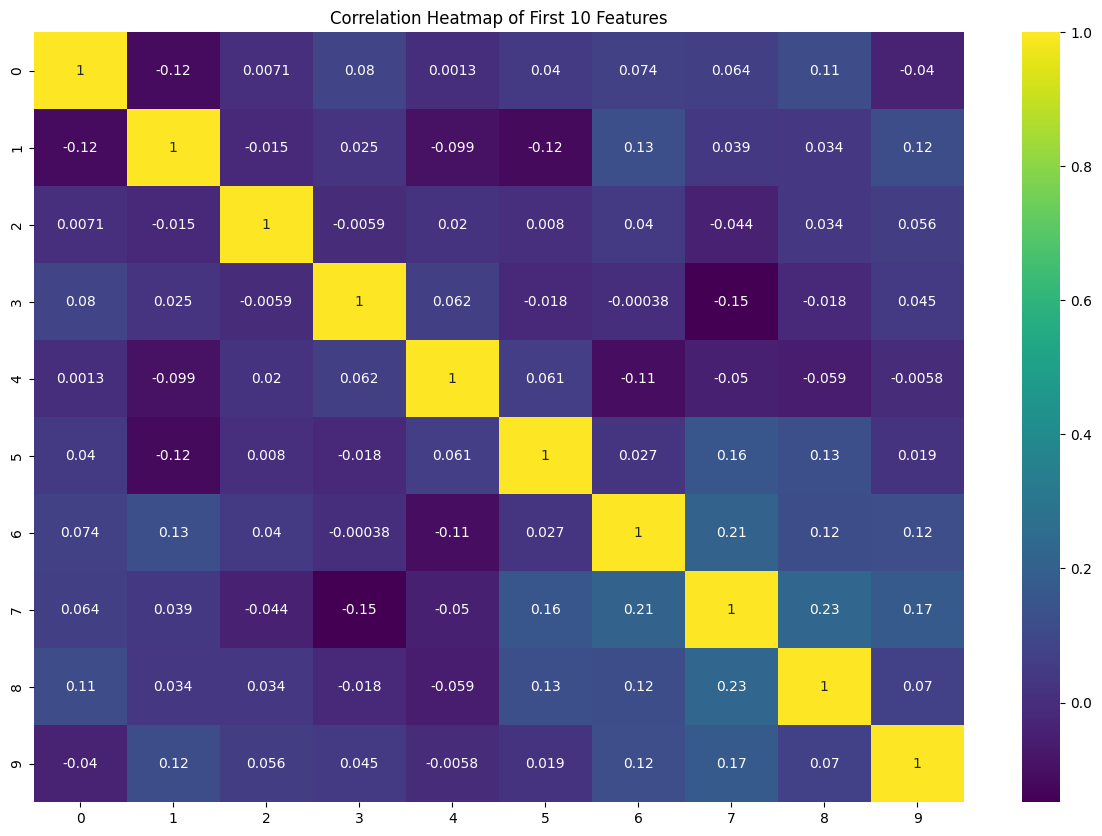

In [10]:
# Heatmap of the first 10 features
plt.figure(figsize=(15, 10))
sns.heatmap(np.corrcoef(data[:, :10].T), annot=True, cmap='viridis')
plt.title('Correlation Heatmap of First 10 Features')
plt.show()

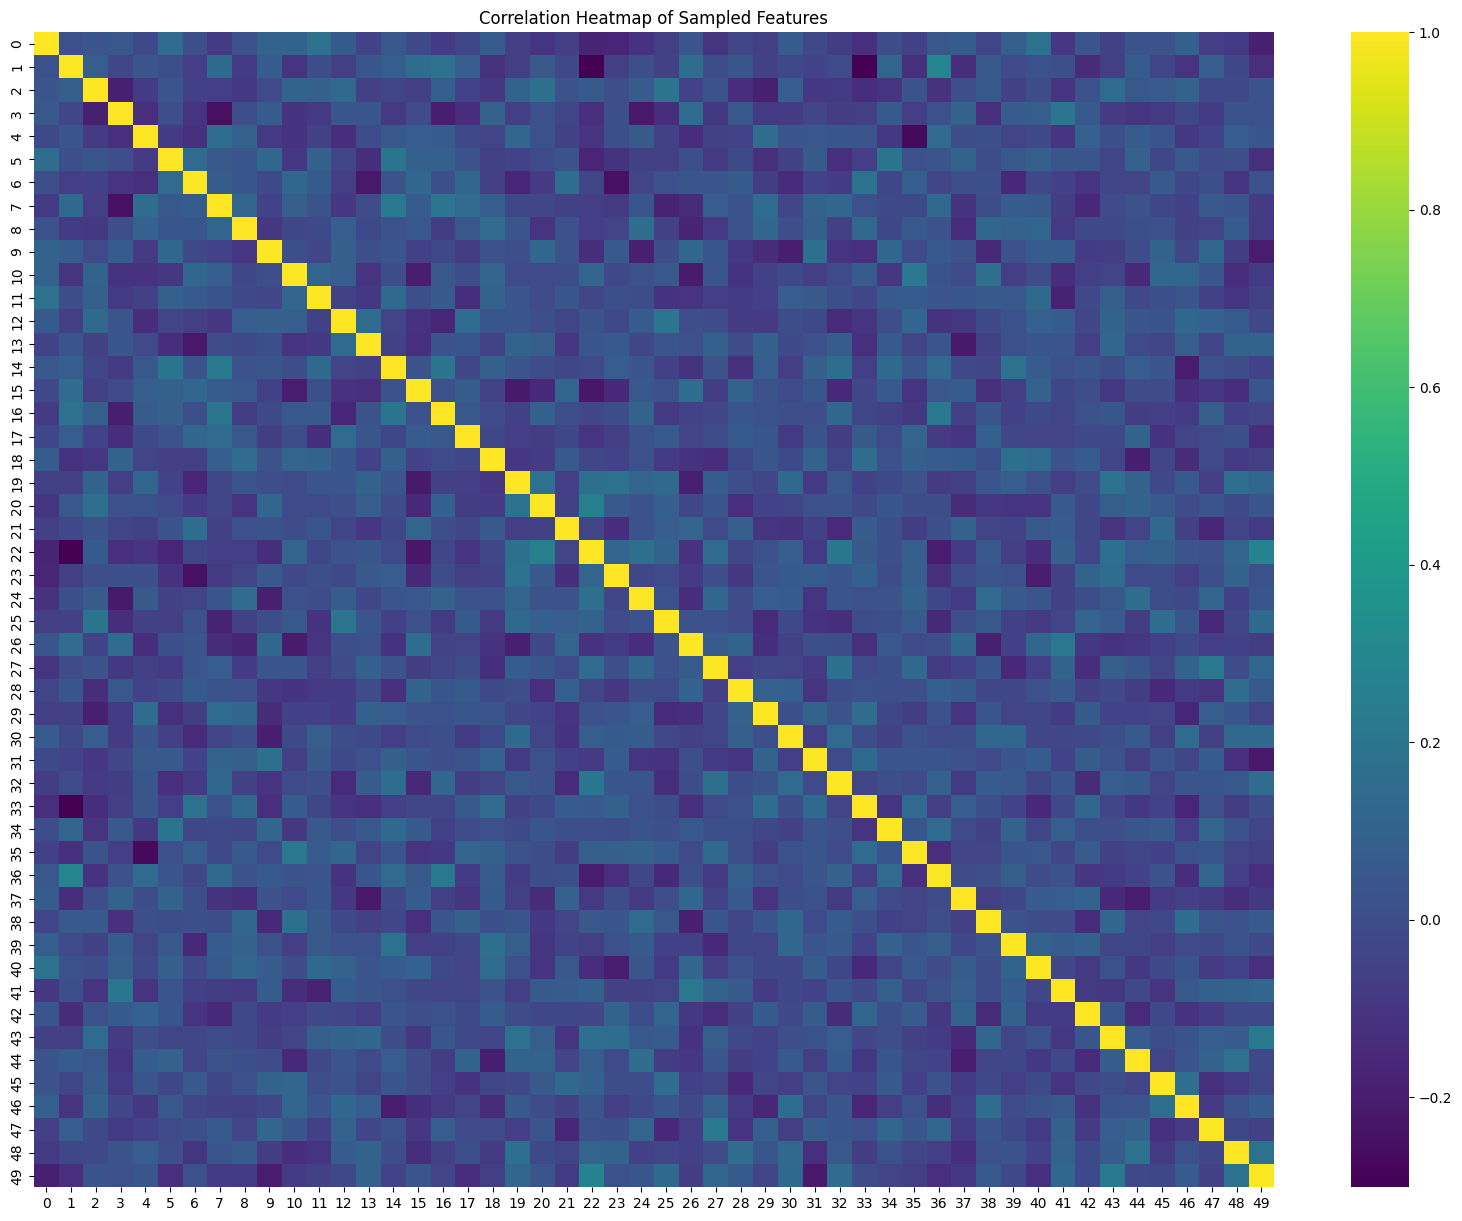

In [11]:
# Due to the large number of columns, we will sample a subset for visualization
num_columns = data.shape[1]
sampled_indices = np.random.choice(num_columns, 50, replace=False)  # Sample 50 column indices
sampled_columns = data[:, sampled_indices]  # Select the sampled columns

# Compute the correlation matrix
corr_matrix = np.corrcoef(sampled_columns, rowvar=False)

# Plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=False, cmap='viridis')
plt.title('Correlation Heatmap of Sampled Features')
plt.show()

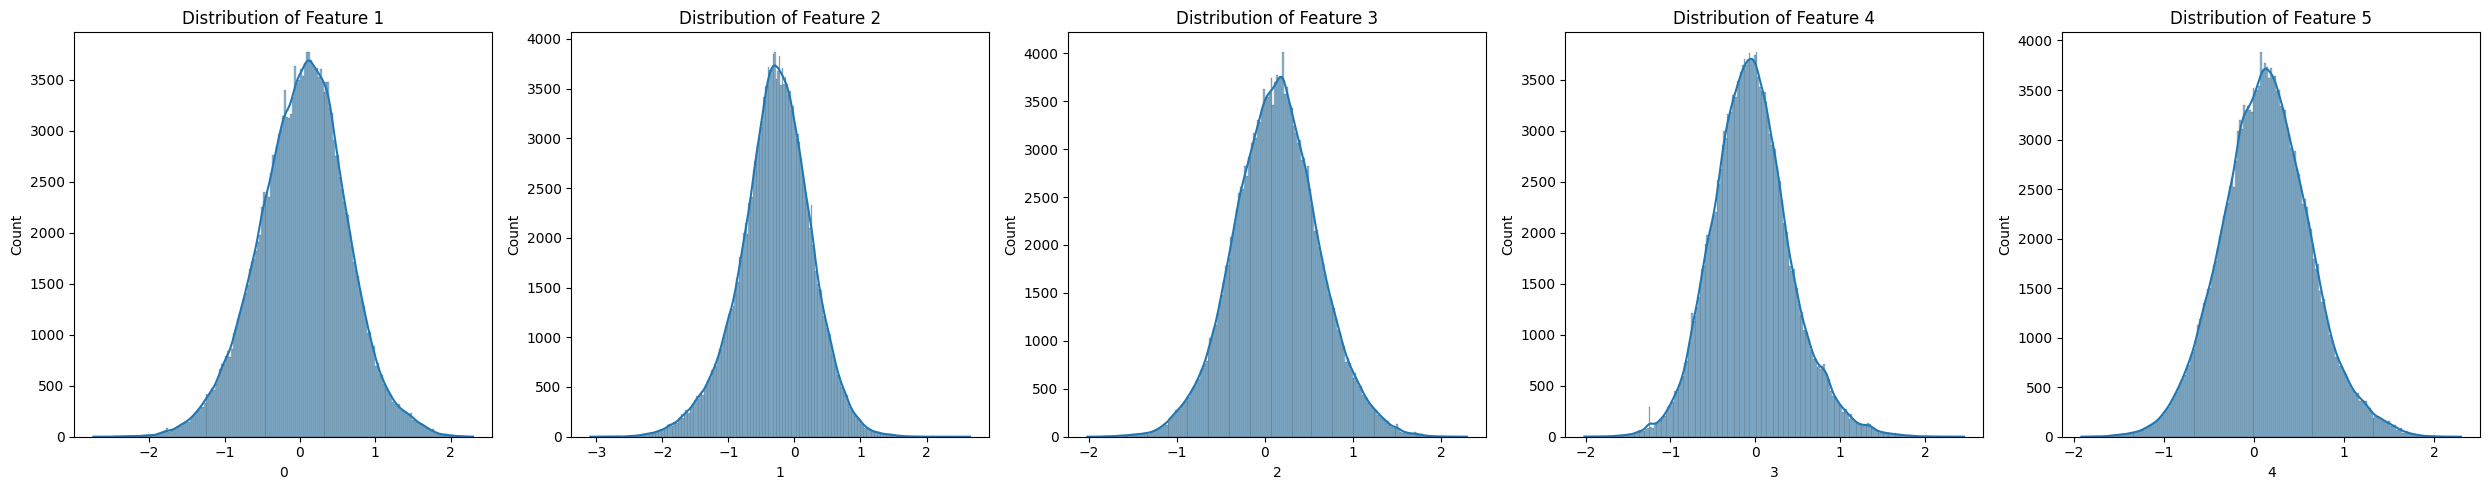

In [12]:
# Convert the standardized data to a DataFrame
data_standardized_df = pd.DataFrame(data)

# Distribution of the first few features
plt.figure(figsize=(25, 5))  # Adjust the figure size for horizontal layout
for i in range(5):
    plt.subplot(1, 5, i+1)  # Change the layout to 1 row and 5 columns
    sns.histplot(data_standardized_df.iloc[:, i], kde=True)
    plt.title(f'Distribution of Feature {i+1}')
plt.tight_layout()
plt.show()

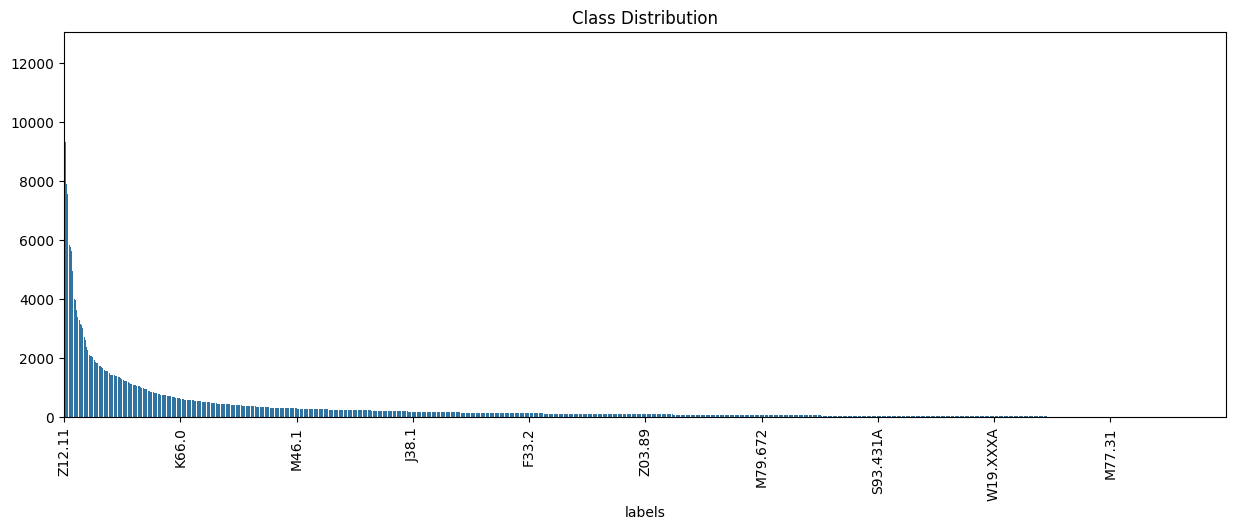

In [13]:
# Check for class imbalance
label_counts = df['labels'].explode().value_counts()

plt.figure(figsize=(15, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Class Distribution')

# Show name of every other ICD code
plt.xticks(rotation=90)
plt.xticks(ticks=range(0, len(label_counts), 140), labels=label_counts.index[::140])

plt.show()

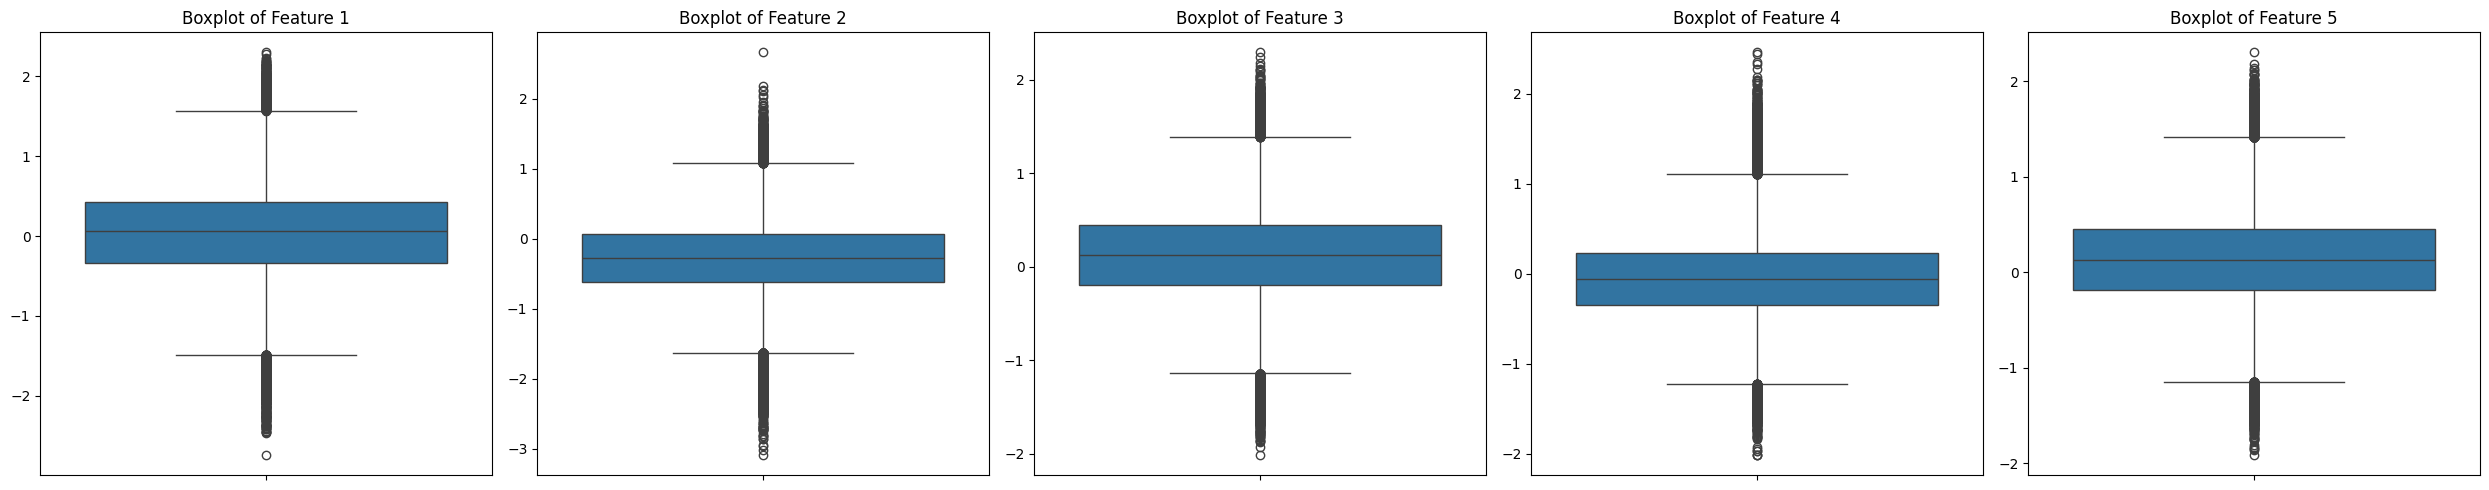

In [14]:
# Boxplot for a subset of features
plt.figure(figsize=(25, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    sns.boxplot(y=data[:, i])
    plt.title(f'Boxplot of Feature {i+1}')
plt.tight_layout()
plt.show()

## Data Engineering

In [15]:
# Parameters
EMBEDDING_DIM = 512          # Embedding dimensions given in data
EPOCHS = 15
BATCH_SIZE = 1024

In [16]:
# Apply PCA to retain 95% variance
pca = PCA(n_components=EMBEDDING_DIM)
data_pca = pca.fit_transform(data)
print(f'Original number of features: {data.shape[1]}')
print(f'Reduced number of features: {data_pca.shape[1]}')

Original number of features: 1024
Reduced number of features: 512


In [17]:
data_pca.shape

(198982, 512)

In [18]:
import numpy as np
from sklearn.utils import resample
import random

def resample_data(data, labels, n_samples_per_class):
    # Initialize a list to store the number of samples per class
    num_labels = [0] * labels.shape[1]
    
    # Initialize lists to store the resampled data and labels
    resampled_data = []
    resampled_labels = []
    
    # Create a dictionary to store data indices for each label
    label_to_indices = {i: [] for i in range(labels.shape[1])}
    
    # Populate the dictionary with indices of data points for each label
    for i in range(labels.shape[0]):
        for label_index in np.where(labels[i] == 1)[0]:
            label_to_indices[label_index].append(i)
    
    # Perform resampling
    while any(count < n_samples_per_class for count in num_labels):
        # Choose a random label that needs more samples
        label_index = random.choice([i for i, count in enumerate(num_labels) if count < n_samples_per_class])
        
        # Choose a random row from the group of data points with the chosen label
        random_index = random.choice(label_to_indices[label_index])
        random_row = data[random_index]
        random_labels = labels[random_index]
        
        # Add the random row to the resampled data and labels
        resampled_data.append(random_row)
        resampled_labels.append(random_labels)
        
        # Update the count for each label in the chosen row
        for label_index in np.where(random_labels == 1)[0]:
            num_labels[label_index] += 1
    
    # Convert the resampled data and labels to numpy arrays
    resampled_data = np.array(resampled_data)
    resampled_labels = np.array(resampled_labels)

    return resampled_data, resampled_labels

# Example usage:
# Assuming `label` is already binarized and `data` is prepared
resampled_data, resampled_labels = resample_data(data_pca, label, n_samples_per_class=1000)

In [19]:
resampled_data.shape, resampled_labels.shape

((812247, 512), (812247, 1400))

In [20]:
dsc = StandardScaler()
resample_scaled = dsc.fit_transform(resampled_data)

In [21]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(resample_scaled, resampled_labels, test_size=0.2, random_state=42)

In [22]:
# Define F2 Score Callback
class F2Score(Callback):
    def __init__(self, x_val, y_val):
        super(F2Score, self).__init__()
        self.x_val = x_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        val_pred = (self.model.predict(self.x_val) > 0.5).astype(int)  # Binarize predictions
        f2 = fbeta_score(self.y_val, val_pred, beta=2, average='micro')  # Calculate F2 score
        print(f"Epoch {epoch + 1}: F2 Score: {f2:.4f}")  # Print F2 score

# Build and train the model
model = models.Sequential([
    layers.Input(shape=(EMBEDDING_DIM,)),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(resampled_labels.shape[1], activation='sigmoid')  # One neuron per label with sigmoid activation
])

# Compile the model with a custom learning rate for the Adam optimizer
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

# Create an instance of the F2Score callback
f2_score_callback = F2Score(X_val, y_val)

# Train the model
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
          validation_data=(X_val, y_val), verbose=1, callbacks=[f2_score_callback])

Epoch 1/15
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Epoch 1: F2 Score: 0.8158
635/635 ━━━━━━━━━━━━━━━━━━━━ 77s 119ms/step - binary_accuracy: 0.9906 - loss: 0.0318 - val_binary_accuracy: 0.9995 - val_loss: 0.0017
Epoch 2/15
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
Epoch 2: F2 Score: 0.9087
635/635 ━━━━━━━━━━━━━━━━━━━━ 73s 114ms/step - binary_accuracy: 0.9995 - loss: 0.0014 - val_binary_accuracy: 0.9997 - val_loss: 9.2208e-04
Epoch 3/15
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Epoch 3: F2 Score: 0.9430
635/635 ━━━━━━━━━━━━━━━━━━━━ 75s 118ms/step - binary_accuracy: 0.9998 - loss: 7.7538e-04 - val_binary_accuracy: 0.9998 - val_loss: 6.1584e-04
Epoch 4/15
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
Epoch 4: F2 Score: 0.9605
635/635 ━━━━━━━━━━━━━━━━━━━━ 74s 116ms/step - binary_accuracy: 0.9998 - loss: 5.0495e-04 - val_binary_accuracy: 0.9999 - val_loss: 4.6094e-04
Epoch 5/15
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Epoch 5: F2 Score: 0.9697
635/635 ━━━━━━━━━━━━━━━━━━━━ 72s 113ms/ste

## prediction

In [ ]:
# Load test data and apply PCA
test_embeddings = np.load('../data/test_data.npy')
test_embeddings_pca = pca.transform(test_embeddings)
test_embeddings_pca = dsc.transform(test_embeddings_pca)

# Make predictions
test_predictions = model.predict(test_embeddings_pca, verbose=1)

# Convert predictions to label format
test_pred_labels = [
    ';'.join(sorted([mlb.classes_[i] for i, prob in enumerate(pred) if prob > 0.5]))
    for pred in test_predictions
]

3110/3110 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\anike\\data\\test_predictions.csv'

In [32]:
from datetime import datetime

# Specify path to save predictions with a unique filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = os.path.join("../data", f"test_predictions_{timestamp}.csv")

# Write predictions to a CSV file in the specified format
with open(save_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['id', 'labels'])  # Write header
    for idx, labels in enumerate(test_pred_labels, start=1):
        writer.writerow([idx, labels])

print(f"Predictions saved to '{save_path}'")

Predictions saved to '../data\test_predictions_20241104_220015.csv'
